In [50]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
from keras import models
from keras import layers

In [28]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [29]:
print(train_data.shape)
print(test_data.shape)
print(train_data[0])

(404, 13)
(102, 13)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


在 boston 房价数据集里，每个数据的维度有 13 个，包括犯罪率，当地财产税等，每个维度的数据的值范围的粒度是不同的，有的从 [0, 1]，有的从 [0, 100] 等，在深度学习中，如果数据是不同粒度的，将会得到失真的学习效果，所以对这类数据学习之前，需要对其进行标准化。最简单的标准化方式是，将每个数据维度的数据减去均值，然后再除以其标准差。

In [30]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

值得注意的是，对于测试数据来说，也必须使用训练数据的均值与标准差，因为任何跟测试数据集相关的计算，都不能使用测试数据的数据。

In [31]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

由于最后的结果是线性回归得到的一个值，这个值是房价，所以不用再进行激活函数变换了。

由于这个数据集数据量很少，一般在数据量不太够的情况下，可以使用 **K-fold交叉验证** 的方式。在 K-fold 交叉验证中，

1. 将可用数据分成 K 份，其中 1 份作为验证数据，K - 1 份为训练数据
2. 对每一叠数据进行训练与验证，得到验证分数
3. 最后对所有验证分数求和，得到最终的验证分数

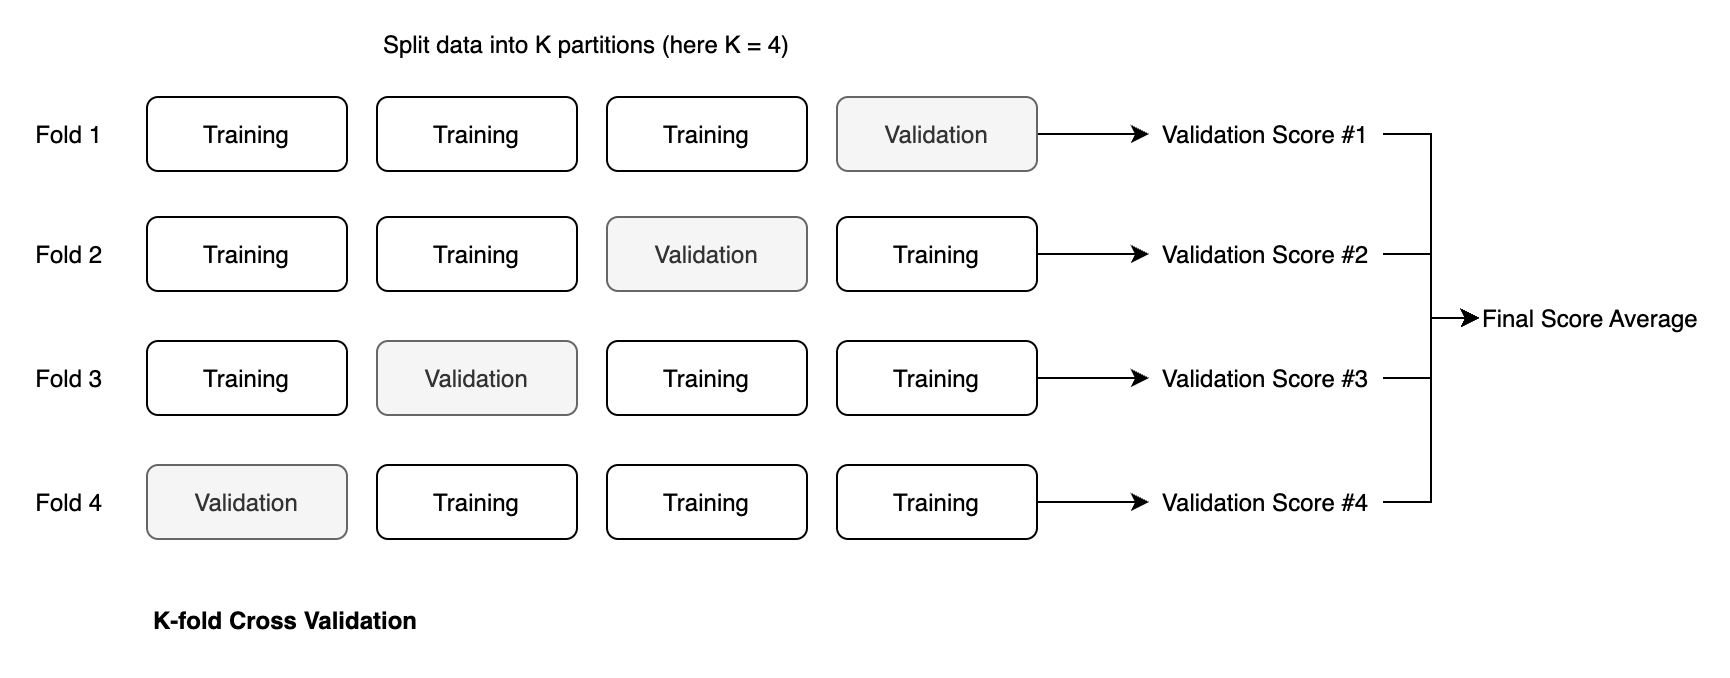

In [46]:
num_epochs = 100

def k_fold_cross_validation():
    k = 4
    num_val_samples = len(train_data) // k
    all_mae_histories = []

    for i in range(k):
        print('proccess fold #', i)
        # prepare validation data
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate([
            train_data[:i * num_val_samples],
            train_data[(i + 1) * num_val_samples:]
        ], axis=0)
        partial_train_targets = np.concatenate([
            train_targets[:i * num_val_samples],
            train_targets[(i + 1) * num_val_samples:]
        ], axis=0)

        model = build_model()

        # train model in silent mode
        history = model.fit(partial_train_data,
                  partial_train_targets,
                  validation_data=(val_data, val_targets),
                  epochs=num_epochs,
                  batch_size=1,
                  verbose=0)
        mae_history = history.history['val_mae']
        all_mae_histories.append(mae_history)

    return all_mae_histories

In [45]:
all_mae_histories = k_fold_cross_validation()

proccess fold # 0
proccess fold # 1
proccess fold # 2
proccess fold # 3


In [49]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

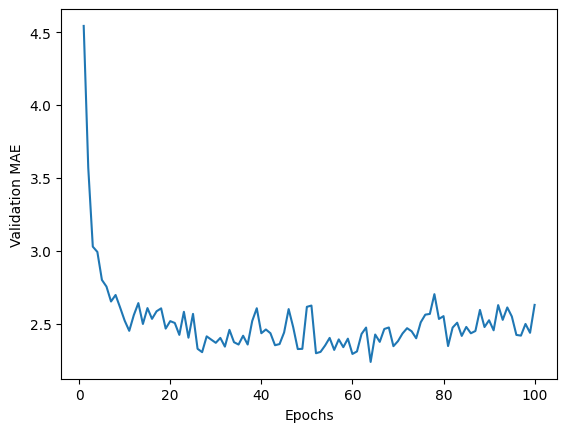

In [51]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [52]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [ ]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()